In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests

In [2]:
# PARAMETERS
run_id="DMRs.07.23.ldcts"

In [3]:
# Parameters
run_id = "group_loops.09.19.ldcts"


In [4]:
ldsc_results=f'/anvil/projects/x-mcb130189/rwang22/bican/ldsc/output/{run_id}'
directory = Path(ldsc_results)
dfs = {}

for file in directory.glob(f'*.cell_type_results.txt'):
    cur = pd.read_csv(file, sep = "\t")
    stripped = file.stem.replace(f'_.cell_type_results', "")
    cur["Trait"] = stripped
    dfs[stripped] = cur

In [5]:
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df["-log10(pval)"] = -np.log10(combined_df["Coefficient_P_value"])
combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")
combined_df.head()

/tmp/ipykernel_1751820/1445883874.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")


,Name,Coefficient,Coefficient_std_error,Coefficient_P_value,Trait,-log10(pval)
0,Microglia-1,1.290937e-08,4.358155e-09,0.001528,Lambert.NatGenet.2013.Alzheimers_Disease_,2.815975
1,Endo,1.177652e-08,4.901004e-09,0.008133,Lambert.NatGenet.2013.Alzheimers_Disease_,2.089735
2,Microglia-2,1.007419e-08,4.839005e-09,0.018677,Lambert.NatGenet.2013.Alzheimers_Disease_,1.728691
3,GPe_SOX6-CTXND1_GABA,7.780616e-09,3.862676e-09,0.021989,Lambert.NatGenet.2013.Alzheimers_Disease_,1.657802
4,STRd_Cholinergic_GABA,8.559456e-09,4.647067e-09,0.032745,Lambert.NatGenet.2013.Alzheimers_Disease_,1.484861


In [6]:
# Perform FDR correction using Benjamini-Hochberg procedure
rejected, q_values, _, _ = multipletests(combined_df["Coefficient_P_value"], alpha=0.05, method='fdr_bh')
combined_df["FDR_BH_corrected"] = q_values

In [7]:
# calculate the FDR p value threshold 
# https://www.r-bloggers.com/2023/07/the-benjamini-hochberg-procedure-fdr-and-p-value-adjusted-explained/

def fdr_bh_adj(df):
    tmp = combined_df.copy()
    tmp["rank"] =  combined_df['Coefficient_P_value'].rank()
    num_tests = len(tmp)
    tmp["adj_pval"] = (num_tests * tmp["Coefficient_P_value"]) / tmp["rank"]

    return tmp


In [8]:
tmp = fdr_bh_adj(combined_df)
# Align indices before comparison
fdr_bh_corrected = combined_df["FDR_BH_corrected"]
adj_pval = tmp["adj_pval"]

print(fdr_bh_corrected.sort_values())

6301    2.274978e-07
6300    2.274978e-07
2460    4.877573e-07
2461    9.133594e-07
5220    1.447383e-06
            ...     
3044    9.999977e-01
3043    9.999977e-01
3042    9.999977e-01
3040    9.999977e-01
7319    9.999977e-01
Name: FDR_BH_corrected, Length: 7320, dtype: float64


In [9]:
print(adj_pval.sort_values())

6301    2.274978e-07
6300    2.891598e-07
2460    4.877573e-07
2461    9.133594e-07
5220    1.447383e-06
            ...     
1194    1.140789e+00
6744    1.140803e+00
1424    1.140803e+00
4216    1.140819e+00
734     1.140850e+00
Name: adj_pval, Length: 7320, dtype: float64


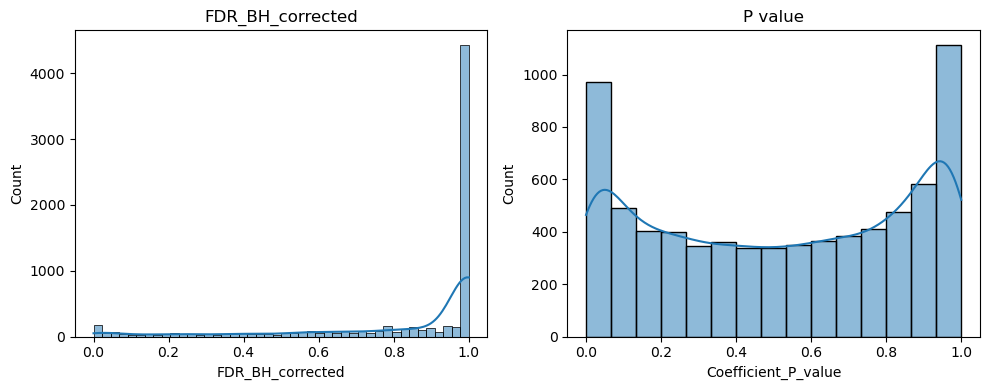

In [10]:
# plot the distribution of p values 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First plot
sns.histplot(combined_df["FDR_BH_corrected"], kde=True, ax=axes[0])
axes[0].set_title("FDR_BH_corrected")

# Second plot
sns.histplot(combined_df["Coefficient_P_value"], kde=True, ax=axes[1])
axes[1].set_title("P value")

plt.tight_layout()
plt.show()

In [11]:
modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', 'FDR_BH_corrected'], axis=1)
modified_df = modified_df.pivot(index="Name", columns="Trait", values="-log10(pval)").reset_index()
modified_df = modified_df.set_index("Name")
modified_df.head()

Trait,Arvanitis.NatCommun.2019.Heart_Failure_,Astle.Cell.2016.Basophil_count_,Astle.Cell.2016.Eosinophil_count_,Astle.Cell.2016.Lymphocyte_count_,Astle.Cell.2016.Monocyte_count_,Astle.Cell.2016.Neutrophil_count_,Aylward.2018.biorxiv.Type_1_Diabetes_,Barban.NatGenet.2016.Age_First_Birth_,Barban.NatGenet.2016.Number_Children_Born_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,...,Yengo.biorxiv.2018.BMI_,Yengo.biorxiv.2018.Height_,Zhu.RespirRes.2019.Hypertension_,deLange.NatGenet.2017.Crohns_Disease_,deLange.NatGenet.2017.Inflammatory_Bowel_Disease_,deLange.NatGenet.2017.Ulcerative_Colitis_,denHoed.NatGenet.2013.Heart_Rate_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_,vandenBerg.BehavGenet.2016.Extraversion_,vanderValk.HumMolGenet.2014.Birth_Length_
Name,,,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.025368,0.123931,0.000144,0.108759,0.020383,0.018010,0.282843,2.190354,0.305854,0.056450,...,1.109934,0.003585,0.005551,0.001548,0.000001,9.788174e-07,0.402796,0.644567,0.437973,0.468530
AMY-SLEA-BNST_GABA,0.758507,0.230729,0.000416,0.010775,0.000676,0.101072,0.080397,0.208865,0.741607,0.334406,...,1.976766,0.043548,0.003057,0.087236,0.024089,1.531578e-02,0.668475,0.072798,0.102795,0.579307
Astrocyte-1,0.115718,0.121482,0.013748,0.171184,0.008789,0.063750,0.064528,0.150860,1.096408,0.041978,...,0.874228,1.547303,0.001189,0.004353,0.000761,7.694123e-03,0.697322,0.146807,0.332085,0.583889
Astrocyte-2,0.210069,0.233344,0.211283,0.114359,0.026639,0.066534,0.023280,0.057414,0.663107,0.006987,...,1.041885,1.594960,0.018814,0.003635,0.000280,5.754033e-04,0.602655,0.146869,0.109802,0.500671
Astrocyte-3,0.434618,0.037186,0.006048,0.061744,0.002250,0.097886,0.048509,0.044704,0.230473,0.036385,...,1.306090,1.729415,0.039117,0.008410,0.001293,3.565482e-03,0.878768,0.160486,0.529431,0.594048


In [12]:
fdr_modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', '-log10(pval)'], axis=1)
fdr_modified_df = fdr_modified_df.pivot(index="Name", columns="Trait", values="FDR_BH_corrected").reset_index()
fdr_modified_df = fdr_modified_df.set_index("Name")
fdr_modified_df.head()

Trait,Arvanitis.NatCommun.2019.Heart_Failure_,Astle.Cell.2016.Basophil_count_,Astle.Cell.2016.Eosinophil_count_,Astle.Cell.2016.Lymphocyte_count_,Astle.Cell.2016.Monocyte_count_,Astle.Cell.2016.Neutrophil_count_,Aylward.2018.biorxiv.Type_1_Diabetes_,Barban.NatGenet.2016.Age_First_Birth_,Barban.NatGenet.2016.Number_Children_Born_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,...,Yengo.biorxiv.2018.BMI_,Yengo.biorxiv.2018.Height_,Zhu.RespirRes.2019.Hypertension_,deLange.NatGenet.2017.Crohns_Disease_,deLange.NatGenet.2017.Inflammatory_Bowel_Disease_,deLange.NatGenet.2017.Ulcerative_Colitis_,denHoed.NatGenet.2013.Heart_Rate_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_,vandenBerg.BehavGenet.2016.Extraversion_,vanderValk.HumMolGenet.2014.Birth_Length_
Name,,,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.128325,0.999998,0.999998,...,0.538381,0.999998,0.999998,0.999998,0.999998,0.999998,0.984510,0.819849,0.960491,0.938292
AMY-SLEA-BNST_GABA,0.746734,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.755453,0.999998,...,0.180035,0.999998,0.999998,0.999998,0.999998,0.999998,0.798469,0.999998,0.999998,0.858418
Astrocyte-1,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.545615,0.999998,...,0.666749,0.314056,0.999998,0.999998,0.999998,0.999998,0.785604,0.999998,0.999998,0.857471
Astrocyte-2,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.804262,0.999998,...,0.571191,0.296416,0.999998,0.999998,0.999998,0.999998,0.847125,0.999998,0.999998,0.914224
Astrocyte-3,0.963090,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,...,0.424155,0.243267,0.999998,0.999998,0.999998,0.999998,0.665546,0.999998,0.893868,0.850768


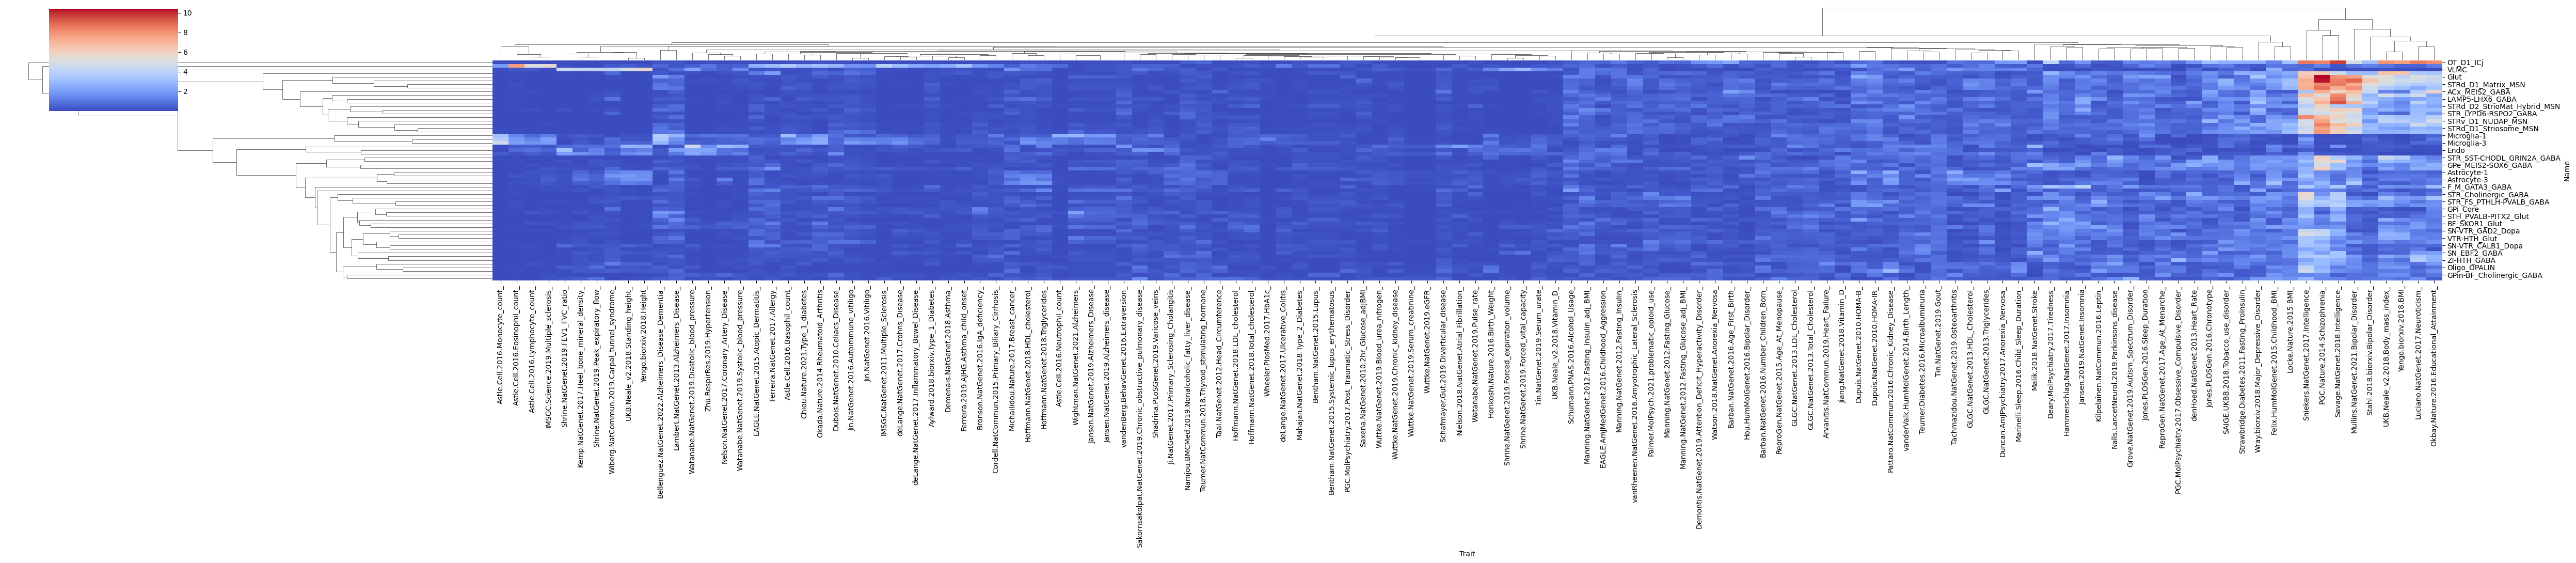

In [13]:
g = sns.clustermap(modified_df, cmap='coolwarm', figsize=(50, 11))

plt.show()
g.savefig(f'output/{run_id}.pdf')

In [14]:
def pval_to_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

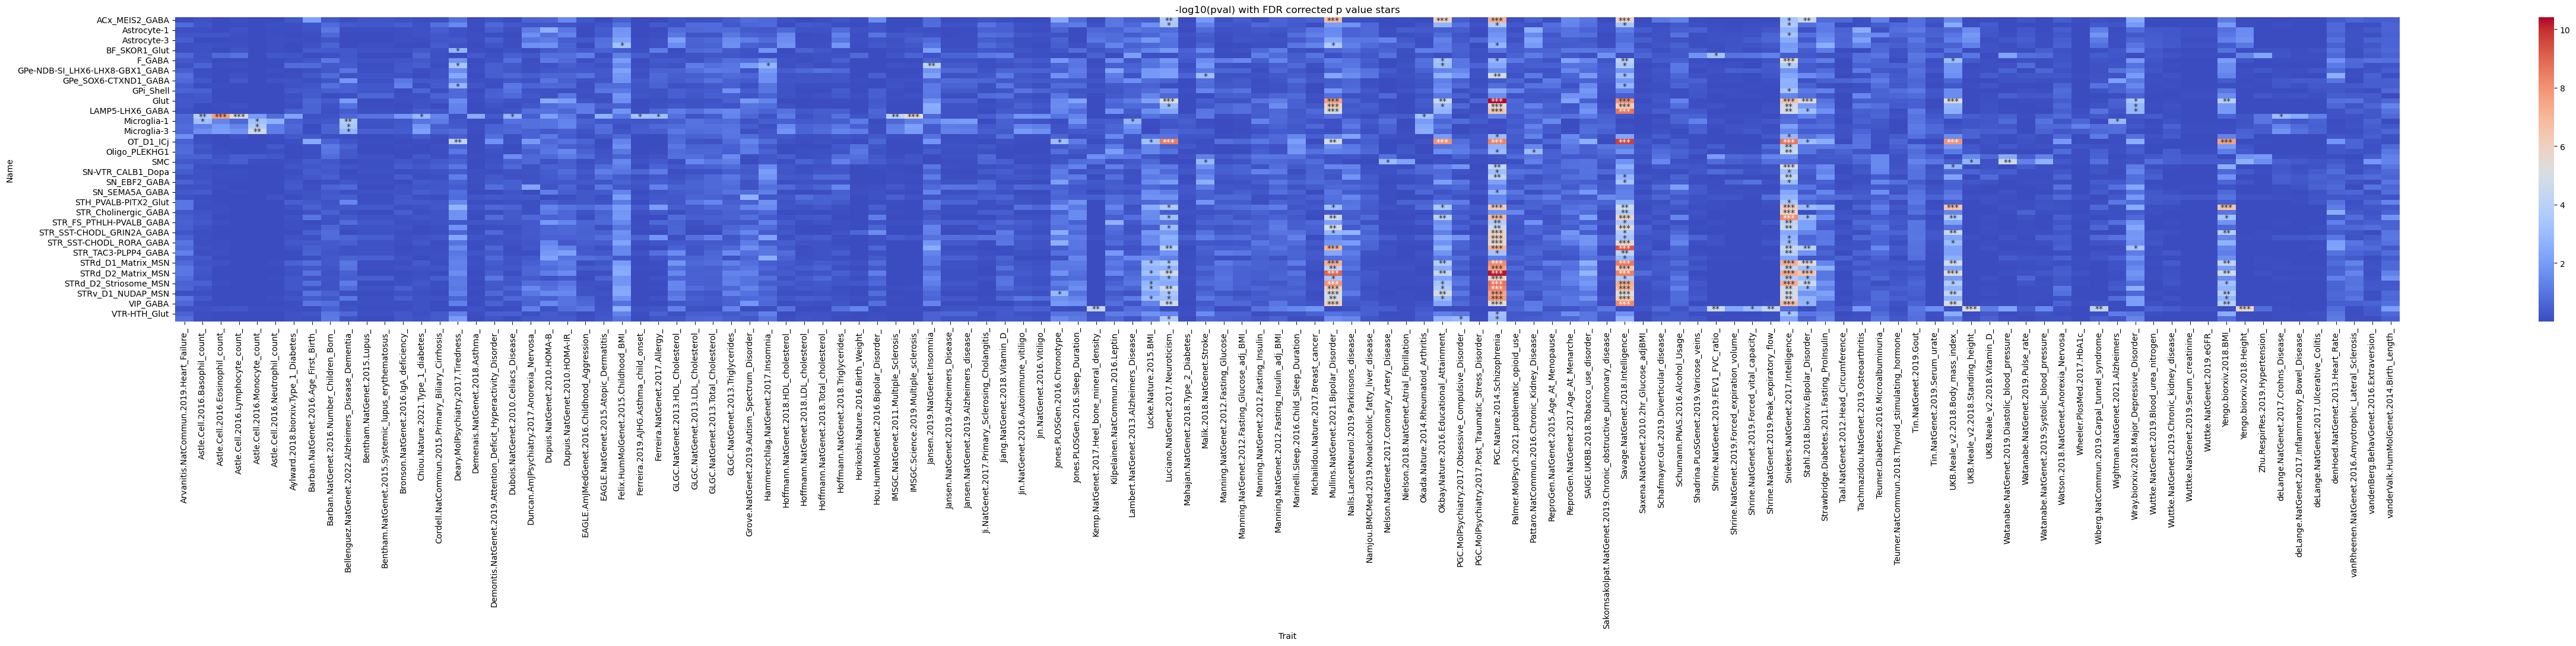

In [15]:
stars = fdr_modified_df.applymap(pval_to_star)

# Plot heatmap with annotations
plt.figure(figsize=(50, 11))
sns.heatmap(modified_df, annot=stars, fmt='', cmap='coolwarm')
plt.title("-log10(pval) with FDR corrected p value stars")
plt.tight_layout()
plt.savefig(f'output/{run_id}_FDR_corrected.pdf')
plt.show()

